In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from helpers.load_data import load_leads_with_deals


from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report,
)
from imblearn.ensemble import BalancedRandomForestClassifier

In [ ]:
df_leads_deals = load_leads_with_deals()

df_leads_deals = df_leads_deals[['mql_id', 'first_contact_date', 'landing_page_id', 'origin', 'conversed_lead']].copy()

df_leads_deals["first_contact_year"] = df_leads_deals["first_contact_date"].dt.year
df_leads_deals["first_contact_month"] = df_leads_deals["first_contact_date"].dt.month
df_leads_deals["first_contact_weekday"] = df_leads_deals["first_contact_date"].dt.day_name()

In [ ]:
df_leads_deals_dummies = pd.get_dummies(df_leads_deals, columns=["landing_page_id", "origin", "first_contact_weekday"])

In [ ]:
df_ordered = df_leads_deals_dummies.sort_values("first_contact_date").reset_index(drop=True)

X = df_ordered.drop(columns=["conversed_lead", "mql_id"])
y = df_ordered["conversed_lead"]

tscv = TimeSeriesSplit(n_splits=5)

fold_metrics = []
feature_importances = []

for fold, (train_index, test_index) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_range = (X_train["first_contact_date"].min(), X_train["first_contact_date"].max())
    test_range = (X_test["first_contact_date"].min(), X_test["first_contact_date"].max())

    X_train_model = X_train.drop(columns="first_contact_date")
    X_test_model = X_test.drop(columns="first_contact_date")

    # precisa ser transformado em função
    
    clf = BalancedRandomForestClassifier(
        n_estimators=500,
        max_depth=10,
        min_samples_leaf=5,
        sampling_strategy="auto",
        random_state=42,
        n_jobs=-1,
    )

    clf.fit(X_train_model, y_train)

    y_pred = clf.predict(X_test_model)
    y_proba = clf.predict_proba(X_test_model)[:, 1]

    fold_metrics.append(
        {
            "fold": fold,
            "train_start": train_range[0],
            "train_end": train_range[1],
            "test_start": test_range[0],
            "test_end": test_range[1],
            "accuracy": accuracy_score(y_test, y_pred),
            "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "recall": recall_score(y_test, y_pred, zero_division=0),
            "f1": f1_score(y_test, y_pred, zero_division=0),
            "roc_auc": roc_auc_score(y_test, y_proba),
        }
    )

    feature_importances.append(clf.feature_importances_)

    print(f"Fold {fold}: train {train_range[0]} → {train_range[1]} | test {test_range[0]} → {test_range[1]}")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("-" * 60)

cv_results = pd.DataFrame(fold_metrics)
print("Cross Validation metrics:")
display(cv_results)

cv_summary = cv_results.describe().loc[["mean", "std"]]
print("Cross Validation Summary:")
display(cv_summary)

feature_importance_df = pd.DataFrame(
    np.mean(feature_importances, axis=0),
    index=X_train_model.columns,
    columns=["mean_importance"],
).sort_values("mean_importance", ascending=False)
print("Feature Importance")
display(feature_importance_df.head(15))


Fold 1: train 2017-06-14 00:00:00 → 2017-10-30 00:00:00 | test 2017-10-30 00:00:00 → 2018-01-19 00:00:00
              precision    recall  f1-score   support

         0.0       0.89      0.58      0.71      1218
         1.0       0.05      0.24      0.09       115

    accuracy                           0.56      1333
   macro avg       0.47      0.41      0.40      1333
weighted avg       0.82      0.56      0.65      1333

------------------------------------------------------------
Fold 2: train 2017-06-14 00:00:00 → 2018-01-19 00:00:00 | test 2018-01-19 00:00:00 → 2018-02-25 00:00:00
              precision    recall  f1-score   support

         0.0       1.00      0.02      0.03      1141
         1.0       0.15      1.00      0.26       192

    accuracy                           0.16      1333
   macro avg       0.57      0.51      0.14      1333
weighted avg       0.88      0.16      0.07      1333

------------------------------------------------------------
Fold 3: train 

,fold,train_start,train_end,test_start,test_end,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
0,1,2017-06-14,2017-10-30,2017-10-30,2018-01-19,0.555139,0.414022,0.052434,0.243478,0.086287,0.400975
1,2,2017-06-14,2018-01-19,2018-01-19,2018-02-25,0.159040,0.508764,0.146230,1.000000,0.255150,0.650549
2,3,2017-06-14,2018-02-25,2018-02-25,2018-03-30,0.236309,0.544028,0.153718,0.973545,0.265512,0.629634
3,4,2017-06-14,2018-03-30,2018-03-30,2018-04-30,0.375844,0.596944,0.167689,0.901099,0.282759,0.684732
4,5,2017-06-14,2018-04-30,2018-04-30,2018-05-31,0.396099,0.607546,0.127353,0.871212,0.222222,0.694349


Cross Validation Summary:


,fold,train_start,train_end,test_start,test_end,accuracy,balanced_accuracy,precision,recall,f1,roc_auc
mean,3.000000,2017-06-14 00:00:00,2018-02-13 09:36:00,2018-02-13 09:36:00,2018-03-28 00:00:00,0.344486,0.534261,0.129485,0.797867,0.222386,0.612048
std,1.581139,NaN,NaN,NaN,NaN,0.153390,0.078267,0.045466,0.314286,0.079217,0.120830


Feature Importance


,mean_importance
first_contact_month,0.184443
first_contact_year,0.131170
landing_page_id_22c29808c4f815213303f8933030604c,0.052225
landing_page_id_b76ef37428e6799c421989521c0e5077,0.049897
origin_email,0.047045
origin_unknown,0.045716
origin_social,0.042012
origin_paid_search,0.034891
first_contact_weekday_Thursday,0.024758
landing_page_id_40dec9f3d5259a3d2dbcdab2114fae47,0.024605


Hold-out metrics:
          accuracy: 0.395
 balanced_accuracy: 0.604
         precision: 0.122
            recall: 0.862
                f1: 0.213
           roc_auc: 0.692


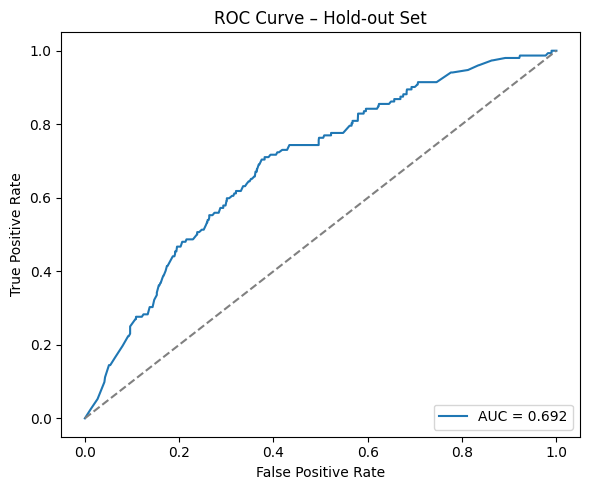

,first_contact_date,actual,predicted,probability
6400,2018-04-24,False,0.0,0.462603
6401,2018-04-24,False,0.0,0.462603
6402,2018-04-24,False,1.0,0.602102
6403,2018-04-24,False,0.0,0.414753
6404,2018-04-24,False,1.0,0.539908
6405,2018-04-24,False,1.0,0.558252
6406,2018-04-24,False,1.0,0.575815
6407,2018-04-24,False,1.0,0.544775
6408,2018-04-24,False,0.0,0.462603
6409,2018-04-24,False,1.0,0.553289


In [ ]:
split_idx = int(len(df_ordered) * 0.8)


train_df = df_ordered.iloc[:split_idx].copy()
test_df = df_ordered.iloc[split_idx:].copy()


X_train = train_df.drop(columns=["conversed_lead", "mql_id"])
y_train = train_df["conversed_lead"]
X_test = test_df.drop(columns=["conversed_lead", "mql_id"])
y_test = test_df["conversed_lead"]

# Keep the date column for reporting but exclude from the model
X_train_model = X_train.drop(columns="first_contact_date")
X_test_model = X_test.drop(columns="first_contact_date")

clf = BalancedRandomForestClassifier(
    n_estimators=500,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
)
clf.fit(X_train_model, y_train)

y_pred = clf.predict(X_test_model)
y_proba = clf.predict_proba(X_test_model)[:, 1]


metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "recall": recall_score(y_test, y_pred, zero_division=0),
    "f1": f1_score(y_test, y_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_test, y_proba),
}
print("Hold-out metrics:")
for name, value in metrics.items():
    print(f"{name:>18}: {value:.3f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {metrics['roc_auc']:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Hold-out Set")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Preview predictions vs actuals
test_results = (
    X_test.assign(
        actual=y_test.values,
        predicted=y_pred,
        probability=y_proba,
    )
    .loc[:, ["first_contact_date", "actual", "predicted", "probability"]]
)
display(test_results.head(20))